# Proba module

The proba module is designed to encode continuous probability distributions on array like objects and simplify manipulation of probability distributions and optimisation tasks on functionals of probability distributions.

The module is constructed around two main classes

- Proba, the probability distribution object.
- ProbabMap, parametric families of probability distributions.

Potential improvements:
- Distribution class, for general measure (potentially signed, etc) and unnormalised posteriors
- Unify output shape checks.

The current demo's goal is to showcase the use of both classes as well as show how custom subclasses can be constructed.

# Proba class

## What is a Proba object?
The Proba class describes a probability distribution. A probability distribution is defined through
- a generator function, which generates samples.
- a log density function (the density being defined wrt some knwon reference distribution).


__No checks are performed to ensure that the generator and log density work well together! This is the user's responsibility.__

For convenience, the shape of the sample can be passed to the distribution when constructing. If it is not passed, it is infered from the generator function. The generator should generate samples as an iterable of ArrayLike object with shape matching sample_shape.

We give exemples of simple manipulation of a Proba object using a Gaussian distribution (subclassed from Proba, methods are modified to increase efficiency).

In [1]:
## Main imports
import numpy as np
import aduq.proba as proba

# Visualisation imports
import seaborn as sns
import matplotlib.pyplot as plt

# We showcase a simple Proba object describing a Gaussian distribution
# Here we use the subclass Gaussian to avoid re-implementation of the log_dens function
mean = np.array([2,0])
cov = .01 * np.array([[2,.4],[.4,2]])

gauss = proba.Gaussian(mean, cov)

A Proba object is defined through 2 mechanisms: a sampler, and its log density function.

### The gen function
Can be called through the 'gen' attribute or simply by calling the proba object

In [2]:
sample = gauss(10000) # Generate a sample
sample = gauss.gen(10000) # Equivalent code

### The log_dens function

The log_dens function is the second main attribute of a proba object. As its name suggests, it computes the log density of the distribution at given points. The reference distribution wrt to which the log-density is computed is assumed known. A good practice consists in using Lebesgue measure.

The log_dens is a 'vectorized' function. Assuming the probability is defined on arrays of shape (d1, ..., dn), the log-density takes as input arrays of shape (n1, ..., nk, d1, ..., dk) and outputs an array of shape (n1, .., nk).

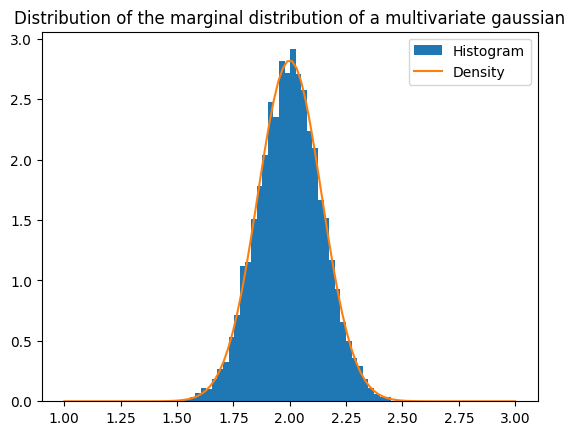

In [3]:
# Define the marginal distribution on the first dimension - this can only be done for Gaussian distributions
sub_gauss = gauss.marginalize([0])

# Plot the histogram of marginal sample on first dimension
plt.hist(sample[:, 0], 40, density=True, label="Histogram")

# Plot the density of the marginal distribution on first dimension
xs = np.linspace(1, 3, 100).reshape((100, 1))
ys = sub_gauss.log_dens(xs)
plt.plot(xs, np.exp(ys), label='Density')
plt.legend()
plt.title("Distribution of the marginal distribution of a multivariate gaussian")
plt.show()

There are no checks during construction that the log-density and generating mechanism work coherently. That is the job of the person implementing the instance. However, if the distribution is well implemented, the transforms encoded in the package should preserve that property.


### Further attributes

A generic proba object contains a further public attribute
- sample_shape, the shape of a single sample point after conversion to np.ndarray

Two private attributes are also logged:
- _sample_size, the number of dimensions of a single sample point (short of np.prod(self.sample_shape))
- _np_out, states whether the output of the gen function are encoded as np.ndarray of shape (n,) + sample_shape

If _np_out is True, some of the implementations are modified to make use of this fact. Good implementation would be to implement a proba instance such that _np_out is True if possible. Since there are some cases where this might not be wanted, it is not enforced by default.

Inherited class might have other attributes, force instance used to pre compute some values. For instance, the Gaussian class has attribute inv_cov, avoiding having to repeatedly compute the inverse when computing the log density.

In [4]:
# The sample_shape attribute inform on the shape of generated samples
assert gauss(10).shape == ( (10, ) + gauss.sample_shape)

## Methods - integrals and metrics
A Proba object can be used to estimate expected values and pseudo distance between probabilities (KL divergence).

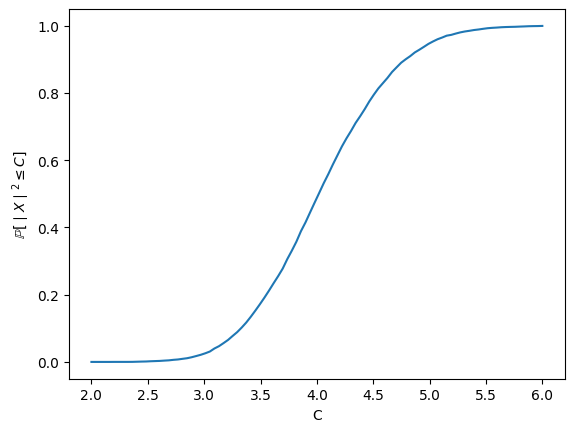

KL between two gaussians: 8593.173330015745


In [5]:
# Integration can be done for functions outputing np.ndarray of any shape of outputing floats/ints,
# and potentially using other arguments.
def fun(x, c ):
    return np.sum(x **2) < c

c = np.linspace(2, 6, 100)

plt.plot(c, gauss.integrate(fun, n_sample = 10000, c = c))

plt.xlabel("C")
plt.ylabel(r"$\mathbb{P}[\mid X\mid^2 \leq C]$")
plt.show()

gauss2 =  proba.Gaussian(np.array([-3, 2]), .1 * cov)
print(f"KL between two gaussians: {gauss.kl(gauss2)}")


## Proba instance from scratch
To construct a Proba instance, one needs two ingredients:
- a way to generate samples from the distribution
- the log density function with respect to a known distribution.

We construct a Proba object describing a uniform distribution from scratch

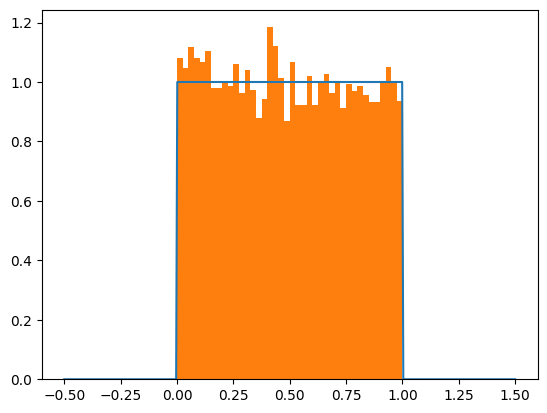

In [6]:
# Consider you want to define the distribution U[0,1]

def gen(n):
    """ 
    numpy is great!
    """
    # It is good practice to consider that the output is a np.ndarray, not a float 
    return np.random.uniform(0,1, (n,1)) 

def log_dens(xs):
    ''' The log density should be vectorized as much as possible'''
    ys = np.array(xs)
    ys = ys.reshape(ys.shape[:-1])
    below_0 = ys < 0
    above_1 = ys > 1
    out = np.zeros(ys.shape)
    out[below_0] = - np.inf
    out[above_1] = - np.inf
    return out

unif = proba.Proba(gen, log_dens, sample_shape = (1,))

xs = np.array(np.linspace(-.5, 1.5, 400).reshape((400,1)))
ys = unif.dens(xs)
plt.plot(xs,ys)
plt.hist(unif(10**4), 40, density=True)
plt.show()

Notice that we had to define the density and the generator independantly. As stated before, no checks are conducted during construction, and it is the user's responsability to pass coherent arguments.

## Inherit from Proba
For specific forms of distribution, one might want to subclass Proba.
For instance,
- Linear transforms of uniforms resulting in uniform distributions. We want to rewrite the lin_transform method to keep that information.
- Moreover, one knows that to estimate integrals of smooth functionals on low dimensional space, Monte Carlo is less efficient than other sampling methods. We want to write a custom integration routines using QMC sampling.

This is done in the followig manner:

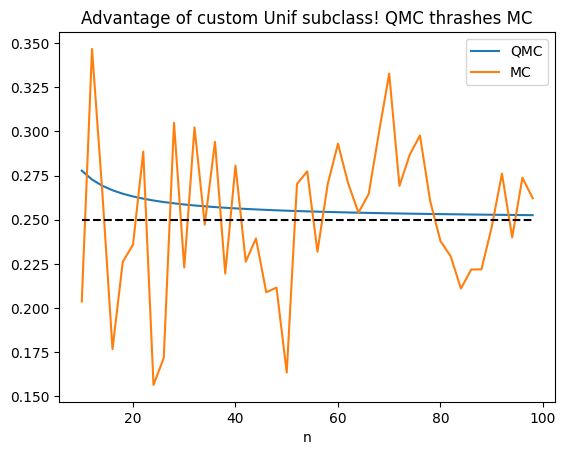

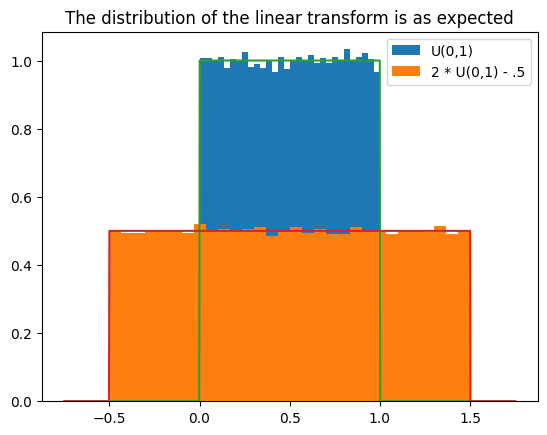

Class of linearly transformed Unif: <class '__main__.Unif'>


In [7]:
# Define a new distribution

class Unif(proba.Proba):
    """ An uniform distribution class """
    def __init__(self, x_min, x_max):

        if x_max < x_min:
            raise Exception(f"{x_min} should be < than {x_max}")

        self.x_min = x_min
        self.x_max = x_max

        def gen(n):
            return np.random.uniform(self.x_min, self.x_max, (n,1))

        dens_val = - np.log(self.x_max - self.x_min)

        def log_dens(xs):
            xs = np.array(xs)
            ys = xs.reshape(xs.shape[:-1])
            below_0 = ys < self.x_min
            above_1 = ys > self.x_max
            out = np.full(ys.shape, dens_val)
            out[below_0] = - np.inf
            out[above_1] = - np.inf
            return out

                
        super().__init__(gen, log_dens, (1,))
        
    def integrate(
        self, 
        func,
        n_sample: int = 100,
        parallel: bool = False,
        **kwargs,
    ):
        # Your custom trick for estimating integrals: evenly spaced samples
        sample = np.linspace(self.x_min, self.x_max, n_sample).reshape((n_sample,1))

        # One should properly give a possibility for parallelization, we'll skip it here
        vals = np.array([func(x, **kwargs) for x in sample])

        if len(vals.shape) > 1: # Check multidimensional output.
            return np.apply_along_axis(np.mean, 0, np.array(vals))

        return np.mean(vals)


    def lin_transform(self, mat: np.ndarray, shift = 0.0):
        # We follow the guidelines for lin_transform
        mat_val = mat[0, 0]
        x_min = self.x_min * mat_val + shift
        x_max = self.x_max * mat_val + shift
        x_min, x_max = min(x_min, x_max), max(x_min, x_max)
        return Unif(x_min, x_max)

std_unif = Unif(0,1)

def func(x):
    return x[0]**3

ns = np.arange(10, 100, 2)
plt.plot(ns, [std_unif.integrate(func, n) for n in ns], label='QMC')
plt.plot(ns, [unif.integrate(func, n) for n in ns], label='MC')
plt.plot(ns, [0.25 for n in ns], "--", c="black")

plt.xlabel("n")
plt.legend()
plt.title("Advantage of custom Unif subclass! QMC thrashes MC")
plt.show()
plt.clf()

# Check that the lin_transform is correctly implemented
plt.hist(std_unif(100000), 30, density=True, label="U(0,1)")

mod_unif = std_unif.lin_transform(mat=np.array([[2.0]]), shift=-0.5)
plt.hist(mod_unif(100000), 30, density=True, label="2 * U(0,1) - .5")
plt.legend()

X = np.linspace(-.75, 1.75, 1000).reshape((1000,1))
Y1 = std_unif.dens(X)
Y2 = mod_unif.dens(X)
plt.plot(X,Y1)
plt.plot(X,Y2)
plt.title("The distribution of the linear transform is as expected")

plt.show()
print(f"Class of linearly transformed Unif: {type(mod_unif)}")

## Methods - Transformations

Since it inherits from Proba, the new class benefits from the already implemented transformation methods which have not been re-implemented.
A useful transform consists in reshaping the output. For instance, we can modify our distribution such that samples are now outputted as np.ndarray of shape (1,1).

More general than lin_transform, the transform transforms the distribution of X to the distribution of f(X) if f is bijective.

(100, 1, 1)


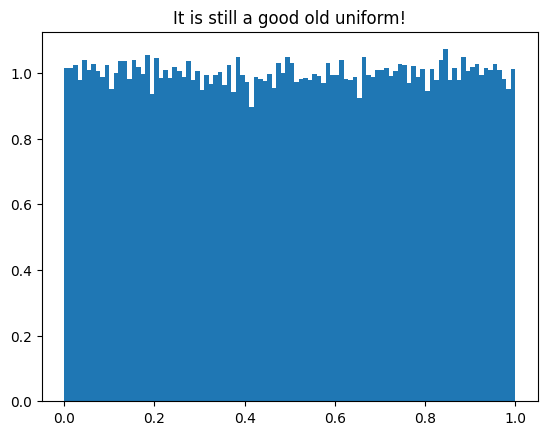

In [8]:
# Test reshape
ini_shape = std_unif.sample_shape
c = std_unif.reshape(ini_shape+(1,))
print(c(100).shape)

# Check that it is still the same good old unif distrib
plt.hist(c(100000).flatten(), 100, density=True)
plt.title("It is still a good old uniform!")
plt.show()

More general than lin_transform, the transform transforms the distribution of X to the distribution of f(X) if f is bijective.

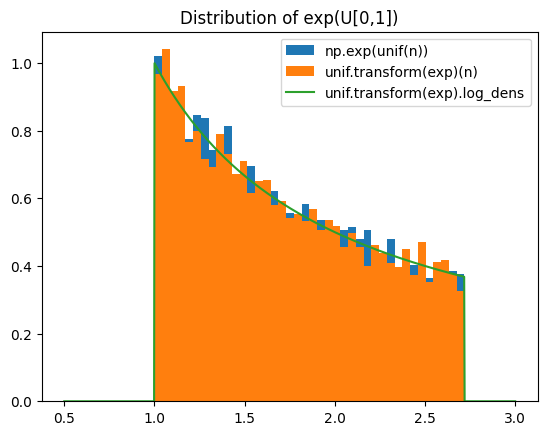

In [9]:
transform = np.exp
inv_transform = np.log 

def der_transform(xs):
    # Here we are considering distributions on outputs of shape (1,) and a transform from (1,) to (1,)
    # The rule is that the der_transform take arrays of shape (n, 1,) and outputs an array of shape (n, 1, 1)
    # (the general rule is (shape_n, shape_in)-> (shape_n, shape_in, shape_out), the derivative being vectorized

    out =  np.exp(xs)
    return out.reshape( xs.shape[:-1] + (1,1))

new_distr = std_unif.transform(transform=transform, inv_transform=inv_transform, der_transform=der_transform)
xs = np.linspace(.5, 3, 1000).reshape((1000, 1))

plt.hist(np.array(new_distr(10000))[:,0], 40, density=True, label='np.exp(unif(n))')
plt.hist(np.array(np.exp(std_unif(10000)))[:,0], 40, density=True, label='unif.transform(exp)(n)' )
plt.plot(xs, new_distr.dens(xs), label='unif.transform(exp).log_dens')
plt.title("Distribution of exp(U[0,1])")
plt.legend()
plt.show()

Apart from transformation, Proba objects can be assembled through tensorisation or mixtures. They can be constructed using a Kernel and a sample through convolution.

For Gaussian, non bijective linear transforms are allowed as long as the transform is sujerective. This behavior is not allowed in the general case, as the log density computation requires integrating.

Another standard operation consists in defining a mixture of distributions. By defaults, distributions are given equal weights though it is possible to specify the weights through the weights argument. 

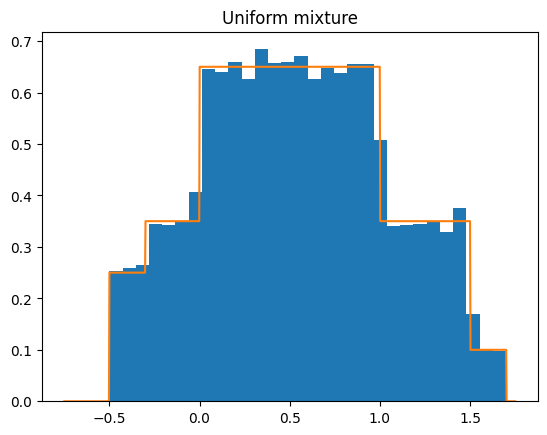

In [10]:
unif_mixture = proba.mixture(std_unif, mod_unif, mod_unif.shift(.2), weights=[.3, .5, .2])
Y3 = np.exp(unif_mixture.log_dens(X))

plt.hist(np.array(unif_mixture(40000)), 30, density=True)
plt.plot(X, Y3)
plt.title("Uniform mixture")
plt.show()

Text(0.5, 1.0, 'Log-Density of a Gaussian mixture')

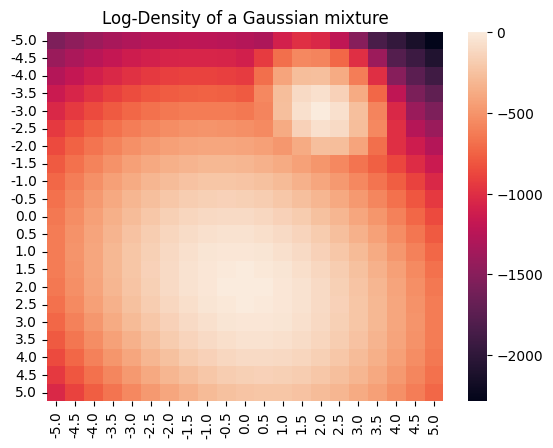

In [11]:
# Showcasing mixture in multidimension
gauss_mixt = proba.mixture(gauss, gauss2)

# A distribution stores essentially two attributes: Sampling and density
# To sample, simply call the distribution
sample = np.array(gauss_mixt(100))

plt.plot(sample[:,0], sample[:, 1], '.')
plt.title("A sample from a 2 dimensional gaussian distribution")
plt.clf()

# The log density of the function can be accessed through log_dens
x_axis_labels = np.linspace(-5,5, 21)
y_axis_labels = np.linspace(-5,5, 21)
values = np.array(np.meshgrid(y_axis_labels, x_axis_labels)).T
values.reshape(values.shape + (1,))

z = gauss_mixt.log_dens(values)
# z = np.array([
#     [ 
#     gauss_mixt.log_dens(np.array([x,y])) for x in x_axis_labels] for y in y_axis_labels]
#     )

sns.heatmap(z, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Log-Density of a Gaussian mixture")

It is important to note that, depending on how the class is coded, there could be side effect when modifying the initial distribution. Here for instance, the distribution A depends on two parameters which can be adjusted afterwards (x_min, x_max). If they are changed, then A changes and the distribution B = 2 * A - .5 is changed in such a way that the relationship is maintained. This can be either useful or a bother, so the subclass should be implemented in whichever way is satisfactory (for side effect, code generator/log_density, and methods using specific attributes used to generate the distribution, i.e. store them as self.x and code with self.x, for no side effect, store them as self._x and code with x).

In [12]:
print("b = a + 10 is defined through custom lin_transform (reimplemented in Unif class)")
b = std_unif.lin_transform(mat = np.array([[1]]), shift=10) 
std_unif.x_max = 1.0
print(f"Maximum value of b when a max={std_unif.x_max}: {np.ceil(np.max(b(1000)))}")

std_unif.x_max = 10.0
print(f"Maximum value of b when a max={std_unif.x_max}: {np.ceil(np.max(b(1000)))}")

std_unif.x_max = 1.0

print("\nb = a + 10 is defined through default shift (not reimplemented in Unif class)")
b = std_unif.shift(10)
std_unif.x_max = 1.0
print(f"Maximum value of b when a max={std_unif.x_max}: {np.ceil(np.max(b(1000)))}")

std_unif.x_max = 10.0
print(f"Maximum value of b when a max={std_unif.x_max}: {np.ceil(np.max(b(1000)))}")

std_unif.x_max = 1.0


b = a + 10 is defined through custom lin_transform (reimplemented in Unif class)
Maximum value of b when a max=1.0: 11.0
Maximum value of b when a max=10.0: 11.0

b = a + 10 is defined through default shift (not reimplemented in Unif class)
Maximum value of b when a max=1.0: 11.0
Maximum value of b when a max=10.0: 20.0


Other methods include computation of pseudo metrics on probablity spaces, the Kullback Leibler divergence or general f-divergences.

In [13]:
n1 = proba.TensorizedGaussian(means= [1], devs=[2])
n2 = proba.TensorizedGaussian(means= [2], devs=[3])
print("n1 = N(1,2), n2 = N(2,3)")
print("kl(n1, n2):", n1.kl(n2, n_sample=1000))
print("kl(n2, n1):", n2.kl(n1, n_sample=1000))
print()
 
print("kl(U[0,1], n1):", std_unif.kl(n1, n_sample=1000))
print("kl(n1, U[0,1]):", n1.kl(std_unif, n_sample=1000))
print()

print("Hellinger(n1, n2):", n1.f_div(n2, lambda x: x ** 2 /2 - .5, n_sample=10000))

n1 = N(1,2), n2 = N(2,3)
kl(n1, n2): 0.17509007952815864
kl(n2, n1): 0.3478508039050142

kl(U[0,1], n1): 1.6544334369441078
kl(n1, U[0,1]): inf

Hellinger(n1, n2): 0.15574877509322588


A distribution object can also be constructed from a sample and a kernel.

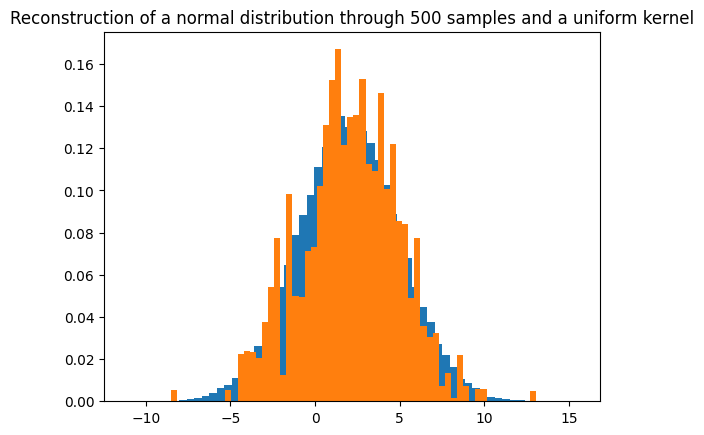

In [14]:
sample = n2(500)
res = proba.proba.from_sample(sample, Unif(0, 1).shift(-.5).contract(.1))

plt.hist(n2(100000)[:, 0], 60, density=True)
plt.hist(np.array(res(100000))[:,0], 60, density=True)

plt.title("Reconstruction of a normal distribution through 500 samples and a uniform kernel")
plt.show()


# ProbaMap

A ProbaMap object is a parametric family of distributions defined on the same space. It is created through a map function (taking a ProbaParam, i.e. an array like object, and outputing a Proba), and a log_dens_der function outputing a closure.

Basically, it is a way to construct Proba objects, with some additional information which are useful when optimising criterias of form

$$\mu \rightarrow \mathbb{E}_{X\sim \mu}[f(X)] + F(\mu)$$

### What is log_dens_der and why does it have to be coded as a function outputing a closure?

log_dens_der is the derivative $\nabla_{\theta}\log( \frac{d\pi_\theta}{d\pi^*}(x)))$, and as such is a function of both $x$ and $\theta$. For families of density of form $C(\theta)f(\theta, x)$, where $C(\theta)$ is a renormalisation constant, coding the derivative as a function of $\theta$ outputing a function of $x$ enables to cache easily the derivative of $C$ with respect to $\theta$ and reuse it for multiple evaluations of $x$.

In [15]:
# Pre-implemented ProbaMap objects are defined for Gaussian distributions
dim = 2

gmap = proba.GaussianMap(dim)
par_shape = gmap.distr_param_shape
distr_param = np.random.normal(0,1, par_shape)

gaussian = gmap(distr_param) # Constructs a Proba object

# Compute KL divergence from distr param
ref_param = gmap.ref_param
kl = gmap.kl(distr_param, ref_param)

# Compute the derivative of the kl
grad, kl2 = gmap.grad_kl(ref_param)(distr_param)
assert kl2 == kl

perturb = np.random.normal(0, 10** (-2), par_shape)
assert np.abs((gmap.kl(distr_param + perturb, ref_param) - kl) / (np.sum(perturb * grad)) - 1) < 10 ** (3)

The ProbaMap class can be used to estimate gradients of integrals with respect to the probability distribution. Note that these estimates require large sample size to be valid, and as such, it is advised not to rely too heavily on this method for Gradient descent style algorithm if the function call is computationnally intensive.

In [16]:
# Estimate the derivative of an integral
def func(x):
    return np.sum(x ** 2)
print("Integral of squared norm")
grad_integral, integral = gmap.integrate_der(func, ref_param, n_sample = 10 ** 5)
print(f"""The obtained delta was  {
    gmap(ref_param + perturb).integrate(func, n_sample = 10 ** 5) - integral
    }""")
print(f"""The Delta estimated through the approximate gradient was {np.tensordot(perturb, grad_integral, ((0, 1), (0, 1)))}\n""")

# Estimate the derivative of multivariate integral (known)
der, empir_means = gmap.integrate_der(lambda x:x, param=gmap.ref_param, n_sample = 10 ** 5)

true_der = np.zeros(gmap.distr_param_shape + (2,))
true_der[0, 0, 0] = 1.0
true_der[0, 1, 1] = 1.0

print(f"Error in derivative computation for identity: {np.sum( (der - true_der)**2)}")

Integral of squared norm
Mean of function: 2.0023393966244822 (deviations: 2.0140141730159735)
The obtained delta was  -0.035847330325472715
The Delta estimated through the approximate gradient was -0.03933354775910697

Mean of function: [-0.00208271  0.00629084] (deviations: [0.99913728 1.00084502])
Error in derivative computation for identity: 0.0012044876631644732


The parametrisation used by a ProbaMap object can be modified using the reparametrize method. This is notably useful for ExponentialFamily, which are defined using their natural parametrisation. We give a trivial exemple of reparametrize.

In [17]:
def transform(x):
    return 2 * x

def inverse(x):
    return x / 2

def der_transform(x):
    """ For reparametrize, it is not necessary to use properly vectorized implementation """
    return 2 * np.eye(np.size(ref_param)).reshape(ref_param.shape + ref_param.shape)

n_gmap = gmap.reparametrize(transform, der_transform, inverse, inherit_methods=True)

import time
# The new parametrisation can be used as before
print(n_gmap.integrate_der(lambda x:x, param=n_gmap.ref_param, n_sample = 10 ** 4))

# This is no longer a GaussianMap object but a general ProbaMap object
print(f"The resulting map is of class: {type(n_gmap )}")

Mean of function: [-0.0019215  -0.00844059] (deviations: [0.99936125 0.98069208])
(array([[[ 1.99744583, -0.040027  ],
        [-0.040027  ,  1.92351393]],

       [[-0.00954799, -0.01341926],
        [-0.03035579, -0.01178745]],

       [[-0.03035579, -0.01178745],
        [-0.00775356,  0.00425457]]]), array([-0.0019215 , -0.00844059]))
The resulting map is of class: <class 'aduq.proba.proba_map.ProbaMap'>


The key feature of reparametrize is method inheritance. Setting inherit_methods=True, the resulting map benefits from previously implemented methods for kl and its derivative. This is of particular interest whenever the kl expression can be written in closed form, which is the case for Exponential families.

In [18]:
# But due to inherit_methods, it benefits from the efficient and exact kl/grad_kl
# computation of the GaussianMap object!
par1, par2 = np.random.normal(0, 1, (2,) + n_gmap.distr_param_shape)
tic = time.time()
n_gmap.grad_kl(par1)(par2)
tac = time.time()
print(f"Using inherit_methods=True: {tac - tic} s. Computation is exact")

# For comparison
n_gmap2 = gmap.reparametrize(transform, der_transform, inverse, inherit_methods=False)
tic = time.time()
n_gmap2.grad_kl(par1)(par2, n_sample = 10**4)
tac = time.time()
print(f"Using inherit_methods=False: {tac - tic} s. Computation is approximate")

Using inherit_methods=True: 0.0021779537200927734 s. Computation is exact
Using inherit_methods=False: 0.0724332332611084 s. Computation is approximate


## Constructing a ProbaMap object from scratch

While some standard parametric distributions are already available, it can be necessary to construct a tailored made ProbaMap object. We show how this can be done, taking as exemple uniform distributions.

In [19]:
# Define a custom ProbaMap
# We encourage defining maps with as little constraints as possible on the parameters passed.
# For instance, Unif(a,b ) requires a < b.
# To bypass that, we can consider Unif( min(a,b), max(a,b) )

class UnifMap(proba.ProbaMap):
    def __init__(self):

        def map(x)->proba.Proba:
            return Unif(np.min(x), np.max(x))

        def log_dens_der(x):
            """ 
            Compute the derivative
            """
            x = np.array(x)
            x_shape = x.shape
            x = x.flatten()
            
            min_x = np.min(x)
            max_x = np.max(x)

            idx_min = (x == min_x) # indices achieving the minimum
            idx_max = (x == max_x)
            
            def der(ys):
                pre_shape = ys.shape[:-1]
                ys = ys.flatten()
                loc = np.zeros((np.prod(pre_shape),np.prod(x_shape)))
                loc[ys == min_x] = -np.inf 
                loc[ys == max_x] = np.inf

                between = (ys < min_x) & (ys > max_x)
                loc[between, idx_max] = - 1/ (max_x - min_x)
                loc[between, idx_min] = 1/ (max_x - min_x)

                if ys == min_x:
                    loc[idx_min] = - np.inf
                if ys == max_x:
                    loc[idx_max] = np.inf
                if (y < min_x) & (y > max_x):
                    # log_dens(y) = -np.log(x[idx_max] - x[idx_min])
                    loc[idx_max] = - 1/ (max_x - min_x)
                    loc[idx_min] = 1 / (max_x - min_x)

                # Remaining case: log_dens(y) = 0 and nothing happens

                return loc.reshape(pre_shape + x_shape)
            
            return der
        super().__init__(map, log_dens_der, ref_param=[0,1], distr_param_shape=(2,), sample_shape=(1,))
        
    def kl(self, param1, param0, n_sample=0, parallel=False):
        if (np.max(param1) == np.max(param0)) and (np.min(param0) == np.min(param1)):
            return 0
        else:
            return np.inf

Using reparametrize, we can change the parametrisation from min and max to the mean and half the width. That can easily be done using the reparametrize method inherited from ProbaMap.

In [20]:
umap = UnifMap()

# Reparametrization
def transform(x):
    return np.array([x[0]- x[1], x[0] + x[1]])

def der_transform(x):
    return np.array([1.0, 1.0], [-1.0, 1.0])

def inv_transform(x):
    return np.array([ .5 * (x[0] + x[1]), .5 * (x[0] - x[1])]) 

n_umap = umap.reparametrize(transform, der_transform, inv_transform, (2,), inherit_methods=True)

Note that reparametrize by default implements methods such as kl and grad_kl using the methods from the object's methods, and not from the generic ProbaMap class. If this is not desirable, one should specify inherit_methods = False.

In [21]:
from time import time
tic = time()
n_umap.kl([0,.5], [0, .6], 10**5)
tac = time()
print(f"Time elapsed after reparametrization: {tac - tic}")

tic = time()
umap.kl([-.5,.5], [-.6, .6], 10**5)
tac = time()
print(f"Time elapsed optimized: {tac - tic}")

Time elapsed after reparametrization: 0.00011372566223144531
Time elapsed optimized: 9.584426879882812e-05


## Exponential families

An important type of probability families are exponential families, whose log-densities share a common form as essentially a scalar product between some representation of $x$ and $\theta$, i.e.
\begin{equation}
\log\left(\frac{d\pi_{\theta}}{d\pi}(x)\right) = \langle \theta, T(x)\rangle - g(\theta) + h(x)
\end{equation}

It is possible to create an exponential family from the class ExponentialFamily, if the functions T, g and h are coded. Specific kl and grad_kl methods are implemented for this subclass, as well as reparametrize to protect these changes.

We give here as an example the construction of gaussian distributions. Note that the ExponentialFamily uses the natural parameters of the exponential family, which might not be the most common ones.

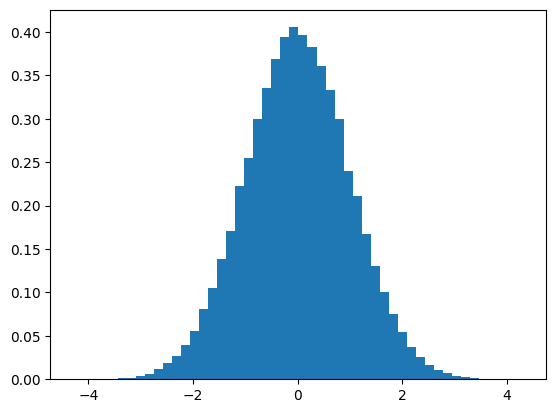

In [22]:
# Gaussians again as deriving from Exponential Family

from math import pi

dim = 1

def get_m_sigma(theta):
    theta = np.array(theta)
    inv_sigma = -2 * theta[1:]
    inv_sigma_m = theta[0]
    sigma = np.linalg.inv(inv_sigma)
    m = sigma @ inv_sigma_m
    return m, sigma

def gen(theta):
    m, sigma = get_m_sigma(theta)
    def loc_gen(n:int):
        return np.random.multivariate_normal(mean = m, cov=sigma, size = n)
    return loc_gen
    
def T(x):
    accu = np.zeros((dim+1, dim))
    accu[0] = x
    accu[1:] = np.outer(x, x)
    return accu

def g(theta):
    inv_sigma = -2 * theta[1:]
    inv_sigma_m = theta[0]
    mu, sigma = get_m_sigma(theta)
    return .5 * (np.sum(mu * inv_sigma_m) + np.log(np.linalg.det(sigma)))

def der_g(theta):
    accu = np.zeros((dim+1,dim))
    m, sigma = get_m_sigma(theta)
    accu[0] = m
    accu[1:] = sigma + np.outer(m, m)
    return accu

def der_der_g(theta):
    # Using the fact that the distribution is one dimensional
    H = np.array([
        [-.5 * theta[1,0] ** (-1),
         .5 * theta[0, 0] * (theta[1,0] ** (-2)) ],
        [.5 * theta[0, 0] * (theta[1,0] ** (-2)), 
         -.5 * (theta[0,0] ** 2) * (theta[1,0] ** (-3)) + .5 * (theta[1,0] ** (-2))  ]])
    return H.reshape((2,1,2,1))

def h(x):
    return - .5 * dim * np.log(2 * pi)

ref_param = np.zeros((dim+1, dim))
ref_param[1:] = -.5 * np.eye(dim)
gmap = proba.ExponentialFamily(
    gen, T, g, der_g, der_der_g, h,
    distr_param_shape= (dim+1,dim), ref_param = ref_param, sample_shape=(dim,))

plt.hist(gmap(gmap.ref_param)(100000)[:,0], 50, density=True)
plt.show()

In [23]:
# Check that the kl/grad_kl computation is correct
d_shape = gmap.distr_param_shape

par1 = np.random.normal(0,1, d_shape) - np.array([[0], [3]])
par2 = np.random.normal(0,1, d_shape) - np.array([[0], [2]])
d_par = np.random.normal(0, 0.001, d_shape)
grad_kl, kl = gmap.grad_right_kl(par1)(par2)
(gmap.kl(par1, d_par + par2) - kl) / np.sum(grad_kl * d_par)

1.0002030348602524

In [24]:
# It is possible to recover the usual parametrisation
def transform(x):
    inter = x[1] ** (-2)
    return np.array([[inter * x[0]], [-.5 * inter]])

def der_transform(x):
    inter = x[1] ** (-2)
    return np.array([
        [inter,                       0              ], 
        [- 2 * x[0] * (x[1] ** (-3)), (x[1] ** (-3)) ]]
        ).reshape((2, 2,1))

def inv_transform(x):
    return np.array([x[0, 0]/ (-2 * x[1,0]), (- 2 * x[1,0]) ** (-1/2)])

standard_gmap = gmap.reparametrize(transform, der_transform, inv_transform, distr_param_shape=(2,))

# Check that the derivative is correct:
x = np.random.normal(0,1,2)
dx = np.random.normal(0, 10**-8, 2)

err = np.max(np.abs((transform(x+dx) - transform(x) )/ np.tensordot(dx, der_transform(x), (0, 0)) -1))
assert err < 10** -4

In [25]:
# We can check that everything is working properly
x = np.random.normal(0,1, (1000, 2))
y = np.random.normal(0,1, (1000, 2))
x[:, 1] = np.abs(x[:, 1])
y[:, 1] = np.abs(y[:,1])

res = np.log(np.abs(y[:,1]/x[:,1])) + (x[:,1] ** 2 + (x[:,0] - y[:,0]) **2 )/ (2 * (y[:,1] ** 2)) - .5
kl_comp = standard_gmap.kl

print(f"Max error in 1000 kl computation: {np.max(np.array([kl_comp(mu1, mu2) for mu1, mu2 in zip(x,y)]) - res)}")

accu = np.zeros(100)
for i in range(100):
    x = np.random.normal(0,1, 2)
    x[1] = np.abs(x[1])

    y = np.random.normal(0,1, 2)
    y[1] = .1 + np.abs(y[1])

    y2 = y + np.random.normal(0, 10**(-6), 2)

    grad_kl = standard_gmap.grad_kl(x)

    accu[i] = (kl_comp(y2, x) - kl_comp(y, x)) / np.tensordot(grad_kl(y)[0],  (y2 - y), (0,0)) - 1
print(f"Max gradient estimation error in 100 computations: {np.max(np.abs(accu))}")


Max error in 1000 kl computation: 3.148770133520884e-11
Max gradient estimation error in 100 computations: 2.0377099494650608e-05


### More on reparametrize

The reparametrize method can also be used when considering a subclass of probability. In that setting, the inverse map is not used, and one should pass the new ref_param. We construct as an example the case the family of probabilities of form

$$ \sigma, \mu \rightarrow\mathcal{N}(\mu, \sigma C)$$

for $C$ a predefined matrix.

Gaussian Distribution
Mean: [0. 0.]
Covariance : [[1.00036661 1.55372321]
 [1.55372321 3.24160206]]
Gaussian Distribution
Mean: [0. 0.]
Covariance : [[ 4.00146645  6.21489284]
 [ 6.21489284 12.96640823]]


/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/proba/proba_map.py:70: UserWarning: No reference parameter passed
Setting array full of 0 as reference parameter
  warnings.warn(


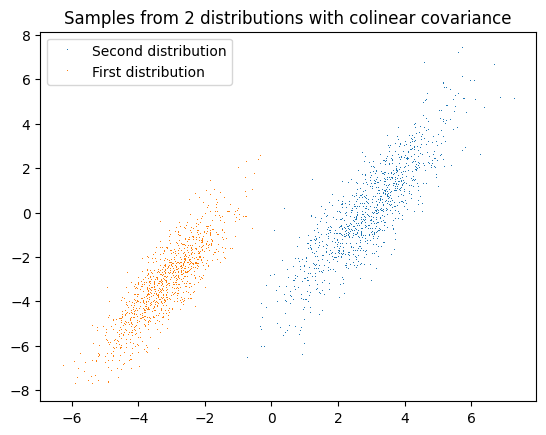

In [26]:
# Constructing a covariance matrix
dim = 2
pre_cov = np.random.normal(0,1,(dim,dim))

def transform(x):
    """ To obtain class \alpha, \sigma ->  N(\alpha, \sigma C) for a fixed C"""
    out = np.zeros((dim+1, dim))
    out[0] = x[:-1]
    out[1:] = x[-1] * pre_cov
    return out

def der_transform(x):
    der_out = np.zeros((dim+1, dim+1, dim))
    der_out[:-1, 0,:] = np.eye(dim)
    der_out[-1, 1:] = pre_cov
    return der_out

# One can check that the derivative is functional
x = np.random.normal(0,1, dim + 1)
dx = np.random.normal(0,0.001, dim + 1)
assert np.max(np.abs((transform(x+dx) - transform(x) )/ np.tensordot(dx, der_transform(x), (0, 0)) - 1)) < 10 ** (-5)

# Construct the NewMap
NewMap = proba.GaussianMap(dim).reparametrize(transform, der_transform, distr_param_shape= (dim+1, ))

x = np.zeros(dim+1)
x[-1] = 1.0
print(NewMap(x))
x[-1] = 2.0
print(NewMap(x))

x = np.random.normal(0,2,dim+1)
x[-1] = 1.0
distr0 = NewMap(x)
sample0 = distr0(1000)

# x[-1] = 2.0
x = np.random.normal(0,2,dim+1)
distr1 = NewMap(x)
sample1 = distr1(1000)
plt.plot(sample1[:,0], sample1[:,1], ",", label="Second distribution")
plt.plot(sample0[:,0], sample0[:,1], ",",  label="First distribution")
plt.legend()

plt.title("Samples from 2 distributions with colinear covariance")
plt.show()

In [27]:
# KL and its gradient computation benefits from the original implementation
grad, kl = NewMap.grad_kl(x)(2 * x)
dx = np.random.normal(0,10**(-6), NewMap.distr_param_shape)
kl_bis = NewMap.kl(2 * x + dx, x)
(kl_bis - kl ) / (np.sum(dx * grad))

1.0000002839666597

# Probability tensorization

In [28]:
gmap1 = proba.GaussianMap(3)
gauss1 = gmap1(np.random.normal(0,1, gmap1.distr_param_shape)).reshape((1,3))
gauss2 = gmap1(np.random.normal(0,1, gmap1.distr_param_shape)).reshape((1, 3))
gauss3 = gmap1(np.random.normal(0,1, gmap1.distr_param_shape)).reshape((1, 3))

distr = proba.tensorize(gauss1, gauss2, gauss3, flatten=False, dim = 0)

y = np.random.normal(0,1, distr.sample_shape)
assert distr.log_dens(y) == gauss1.log_dens(y[:1]) + gauss2.log_dens(y[1:2]) + gauss3.log_dens(y[2:3])

### Combinations of ProbaMap objects
So far, only tensorization of ProbaMaps objects is supported.

The new parametrisation takes flat array which are split and reshaped in order. The resulting ProbaMap object benefits from the methods of the initial ProbaMap objects when computing kl and its gradients.

In [29]:
# Proba Map
gmap1 = proba.GaussianMap(3)
gmap2 = proba.GaussianMap(2)

gmap_tot = proba.map_tensorize(gmap1, gmap2)
print(f"The resulting ProbaMap takes flat inputs: {gmap_tot.distr_param_shape}")

par, par2 = np.random.normal(0,1, (2,) + gmap_tot.distr_param_shape)
tic = time()
gmap_tot.grad_kl(par)(par2)
tac = time()
print(f"KL/Grad KL computation times should be efficcient: {tac - tic} s")

accu = []
for _ in range(10):
    param =  np.random.normal(0,1, 18)
    grad_kl = gmap_tot.grad_kl(param)
    for _ in range(100):
        param1 = np.random.normal(0,1, 18)
        delta_par = np.random.normal(0,10 ** -7, 18)

        der_kl, kl = grad_kl(param1)
        _, kl2 = grad_kl(param1 + delta_par)
        accu.append((kl2 -kl) / np.sum(der_kl * delta_par))

print(f"Max KL gradient estimation error in 10 * 100 tries: {np.max(np.abs(np.log(accu)))}")

param = np.random.normal(0,1,18)

gaussian_distr = gmap_tot(param)
log_dens_der = gmap_tot.log_dens_der(param)

delta_param = np.random.normal(0,10 ** -7, 18)

d_gaussian_distr = gmap_tot(param + delta_param)
sample = gaussian_distr(200)

accu = []
for y in sample:

    delta_log = d_gaussian_distr.log_dens(y) - gaussian_distr.log_dens(y)

    pred_delta_log = np.sum(log_dens_der(y) * delta_param)
    accu.append(delta_log/pred_delta_log)

print(f"Max log-dens gradient estimation error in {len(sample)} trials: {np.max(np.abs(np.log(accu)))}")


The resulting ProbaMap takes flat inputs: (18,)
KL/Grad KL computation times should be efficcient: 0.0030088424682617188 s
Max KL gradient estimation error in 10 * 100 tries: 0.001973207513797562
Max log-dens gradient estimation error in 200 trials: 5.037193656573056e-05


## Implementation checks

Implementations of sub family of ProbaMap should be thoroughly tested before use. To help that, functions in submodule _test can be used. These functions are designed to perform routine checks to see whether the grad_kl/grad_right_kl, log_dens_der and log_dens functions are coherent.

In [30]:
from aduq.proba.gauss import FixedCovGaussianMap, FactCovGaussianMap
from aduq.proba.gauss.TGauss import TensorizedGaussianMap

import aduq.proba._test as test
tgm = TensorizedGaussianMap
FiCGM = FixedCovGaussianMap
FaCGM = FactCovGaussianMap

import numpy as np

test.check_grad_kl( tgm(sample_shape=(2,)))
test.check_grad_right_kl( tgm(sample_shape=(2,)))
test.check_log_dens_der( tgm(sample_shape=(2,)))

test.check_grad_kl( FiCGM(sample_shape=(2,)))
test.check_grad_right_kl( FiCGM(sample_shape=(2,)))
test.check_log_dens_der( FiCGM(sample_shape=(2,)))

test.check_grad_kl( FaCGM(sample_shape=(2,)))
test.check_grad_right_kl( FaCGM(sample_shape=(2,)))
test.check_log_dens_der( FaCGM(sample_shape=(2,)), delta=10 ** -8, tol= 0.02)

Max error for 10*10*10 repeats of 5.518985943187005e-05
Max error for 10*10*10 repeats of 0.0005219305817958375
Max error for 10*10*10 repeats of 0.0001344129708960029
Max error for 10*10*10 repeats of 5.054108166424598e-06
Max error for 10*10*10 repeats of 4.9294711540914804e-05
Max error for 10*10*10 repeats of 0.00036853817749116224
Max error for 10*10*10 repeats of 0.0049281647507183335
Max error for 10*10*10 repeats of 0.00022977946156643725
Max error for 10*10*10 repeats of 2.0806632657466295e-05


## Uniform priors: the gaussian point of view

In the following part, we exhibit how the ease of use of gaussian distributions could be combined with uniform priors requirement. For simplicity, we consider that the prior should be uniform on a hypercube $[0,1]^d$. Variants could be defined on hyper-rectangles or even on hyperspheres.

The key idea is simple: if $X_1, \dots, X_n$ are drawn i.i.d. from $N(0,1)$, then $(F^{-1}(X_1), \dots, F^{-1}(X_n))$ is drawn uniformly on the hypercube (for hypershere prior, consider renormalisation of $X$ by appropriate quantity $f(\lVert X\rVert)$).

We're ready to construct a family distributions on $[0,1]^d$: Consider $F^{-1}(N(\mu, \Sigma))$ where $F^{-1}$ is applied component wise. This mapping preserves groups independence. It is also increasing component-wise, so that it preserves stochastic dominance (for gaussian, stochastic dominanc partial order can only be assessed between distributions with same variance).

In [31]:
## Gaussian to Uniform mapping.
ghmap = proba.GaussHypercubeMap(2)

x_axis_labels = np.linspace(10**-4,1 - 10** -4, 181)
y_axis_labels = np.linspace(10**-4,1- 10 ** -4, 181)
values = np.array(np.meshgrid(y_axis_labels, x_axis_labels)).T

The resulting distributions take values on the hypercube, and as such are good candidates for approximations of posterior. Reminiscent of beta distributions, the distributions can take different forms. If the covariance is smaller than identity, the distributions are unimodal. If this is not the case, the distribution can put more mass on some of the boundaries

([], [])

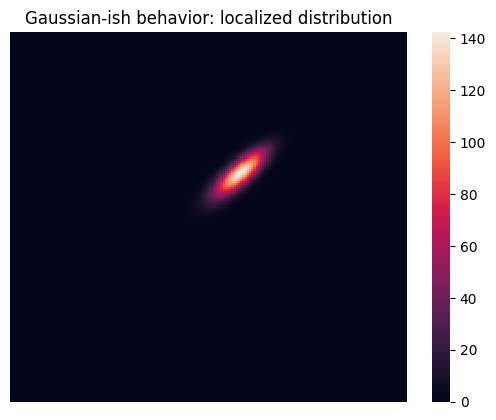

In [32]:
prob = ghmap(np.array(
    [[-0.3, 0.2],
    [.1,-0.05],
    [-0.05, .1]]))

z = prob.dens(values)

sns.heatmap(z, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Gaussian-ish behavior: localized distribution")
plt.xticks([])
plt.yticks([])

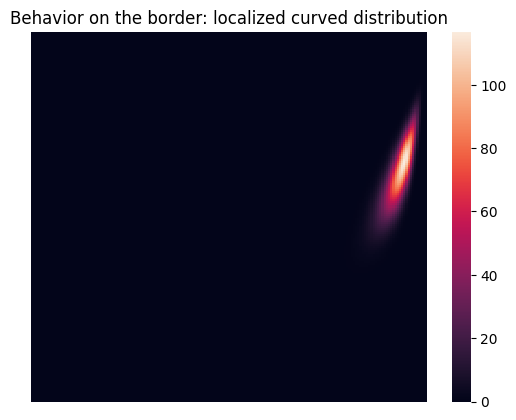

In [33]:
prob = ghmap(np.array([[-.3,1.5], [.2,-0.1], [-0.1, .2]]))

z = prob.dens(values)

sns.heatmap(z, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Behavior on the border: localized curved distribution")
plt.xticks([])
plt.yticks([])
plt.show()

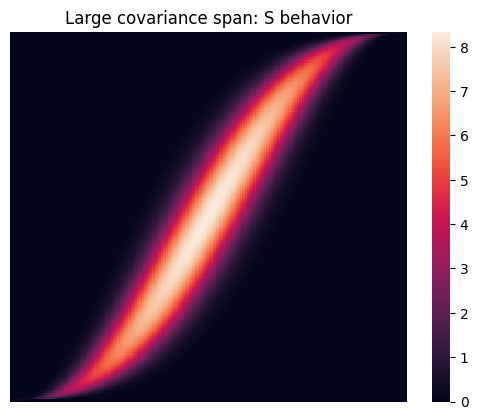

In [34]:
prob = ghmap([[0.0,0.0], [0.7,-0.3], [-0.3, .3]])

z = prob.dens(values)

sns.heatmap(z, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Large covariance span: S behavior")
plt.xticks([])
plt.yticks([])
plt.show()

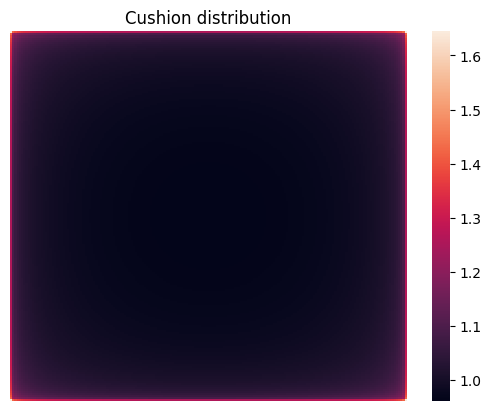

In [35]:
prob = ghmap([[0.0,0.0], [1.02,0.0], [0.0, 1.02]])

z = prob.dens(values)

sns.heatmap(z, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Cushion distribution")
plt.xticks([])
plt.yticks([])
plt.show()

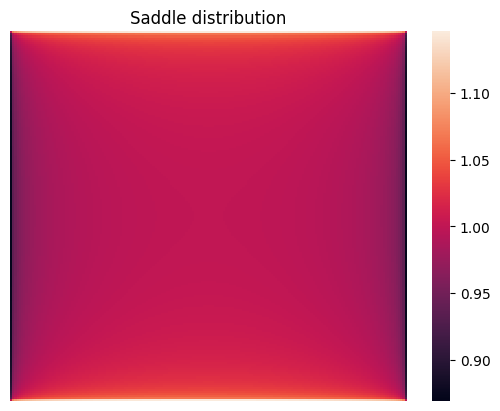

In [36]:
prob = ghmap([[0.0,0.0], [1.01,0.0], [0.0, 0.99]])

z = prob.dens(values)
sns.heatmap(z, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Saddle distribution")
plt.xticks([])
plt.yticks([])
plt.show()

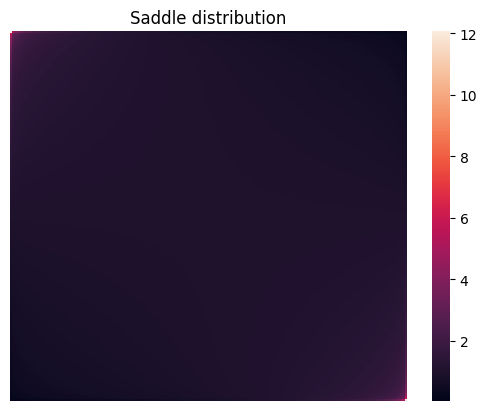

In [37]:
prob = ghmap([
    [0.0,0.0],
    [1.0,0.0],
    [0.2, 1.0]])

z = prob.dens(values)
sns.heatmap(z, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Saddle distribution")
plt.xticks([])
plt.yticks([])
plt.show()

In [38]:
from aduq.proba.gauss.Gauss.gaussian_map import make_cov

In [39]:
def make_param(c):
    vals, vects = np.linalg.eigh([[1.0, c], [c, 1.0]])
    pre_cov =  (vals ** .5) * vects.T
    out = np.zeros((3,2))
    out[1:] = pre_cov
    return out

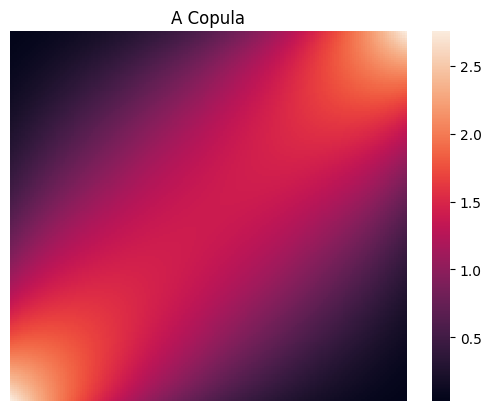

In [40]:
prob = ghmap(make_param(-.7))

x_axis_labels = np.linspace(.1, .9, 181) # Avoid renormalisation issue at the angles
y_axis_labels = np.linspace(.1, .9, 181)
values = np.array(np.meshgrid(y_axis_labels, x_axis_labels)).T

z = prob.dens(values)
sns.heatmap(z, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("A Copula")
plt.xticks([])
plt.yticks([])
plt.show()

(array([0.9800261 , 0.97602599, 1.06002823, 1.03202748, 0.96002556,
        1.07602865, 0.96402567, 0.91202428, 1.12402993, 1.10002929,
        1.00402673, 0.94402514, 0.94402514, 1.04002769, 1.08802897,
        0.93602492, 1.00002663, 0.95602546, 1.07602865, 1.05202801,
        0.97202588, 1.05602812, 0.90402407, 1.00402673, 1.05602812,
        1.02002716, 1.0440278 , 0.84002237, 0.94402514, 1.00402673,
        1.02802737, 0.9800261 , 1.06002823, 1.02002716, 0.93202482,
        1.00402673, 0.94402514, 0.97202588, 0.99202642, 1.00002663]),
 array([2.36806370e-05, 2.50230149e-02, 5.00223493e-02, 7.50216836e-02,
        1.00021018e-01, 1.25020352e-01, 1.50019687e-01, 1.75019021e-01,
        2.00018355e-01, 2.25017689e-01, 2.50017024e-01, 2.75016358e-01,
        3.00015692e-01, 3.25015027e-01, 3.50014361e-01, 3.75013695e-01,
        4.00013030e-01, 4.25012364e-01, 4.50011698e-01, 4.75011033e-01,
        5.00010367e-01, 5.25009701e-01, 5.50009035e-01, 5.75008370e-01,
        6.00007704e-01

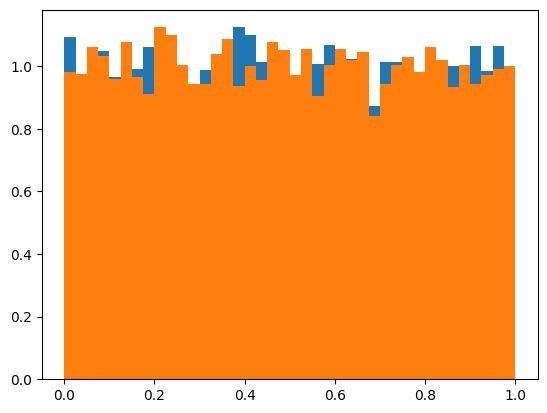

In [41]:
plt.hist(prob(10**4)[:, 0], 40, density=True)
plt.hist(prob(10**4)[:, 1], 40, density=True)